In [41]:
import torch
import gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class AgentConfig:
    # Learning
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01

    # Memory
    memory_size = 400

    train_cartpole = True

class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x


class Agent(AgentConfig):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.action_size = self.env.action_space.n  # 2 for cartpole
        if self.train_cartpole:
            self.policy_network = MlpPolicy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        obs, reward, terminal, info = self.env.step(action)
        return obs, reward, action, terminal

    def train(self):
        episode = 0
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        # A new episode
        while not solved:
            start_step = step
            episode += 1
            episode_length = 0

            # Get initial state
            state, reward, action, terminal = self.new_random_game()
            current_state = state
            total_episode_reward = 1

            # A step in an episode
            while not solved:
                step += 1
                episode_length += 1

                # Choose action
                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))
                # print(prob_a)
                action = torch.distributions.Categorical(prob_a).sample().item()

                # Act
                state, reward, terminal, _ = self.env.step(action)
                new_state = state

                reward = -1 if terminal else reward

                self.add_memory(current_state, action, reward/10.0, new_state, terminal, prob_a[action].item())

                current_state = new_state
                total_episode_reward += reward

                if terminal:
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)

                    if episode > 300:
                        solved = True

                    print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                          'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                                                    self.scheduler.get_lr()[0]))

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0:
                plot_graph(reward_history, avg_reward)

        self.env.close()
        return reward_history

    def update_network(self):
        # get ratio
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']))
        old_probs_a = torch.FloatTensor(self.memory['action_prob'])
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        # surrogate loss
        surr1 = ratio * torch.FloatTensor(self.memory['advantage'])
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage'])
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - self.memory['td_target']).pow(2)  # Huber loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy])
        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = torch.FloatTensor(reward) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state)) * torch.FloatTensor(terminal)
        delta = td_target - self.policy_network.v(torch.FloatTensor(state))
        delta = delta.detach().numpy()

        # get advantage
        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'], td_target.data), dim=0)
        self.memory['advantage'] += advantages


def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(np.array(df['x']), np.array(df['Reward']), marker='', color=palette(1), linewidth=0.8, alpha=0.9, label='Reward')

    # plt.legend(loc='upper left')
    plt.title("CartPole", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

    plt.savefig('score.png')

In [45]:
reward_list = []

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 1.00, total step: 55.00, last_episode length: 55.00, last_episode_reward: 54.00, loss: 0.0000, lr: 0.0200
episode: 2.00, total step: 69.00, last_episode length: 14.00, last_episode_reward: 13.00, loss: -1.2314, lr: 0.0200
episode: 3.00, total step: 106.00, last_episode length: 37.00, last_episode_reward: 36.00, loss: -1.0915, lr: 0.0199
episode: 4.00, total step: 122.00, last_episode length: 16.00, last_episode_reward: 15.00, loss: -1.0369, lr: 0.0199
episode: 5.00, total step: 138.00, last_episode length: 16.00, last_episode_reward: 15.00, loss: -0.9688, lr: 0.0199
episode: 6.00, total step: 165.00, last_episode length: 27.00, last_episode_reward: 26.00, loss: -0.9097, lr: 0.0199
episode: 7.00, total step: 177.00, last_episode length: 12.00, last_episode_reward: 11.00, loss: -0.8781, lr: 0.0199
episode: 8.00, total step: 208.00, last_episode length: 31.00, last_episode_reward: 30.00, loss: -0.8400, lr: 0.0198
episode: 9.00, total step: 252.00, last_episode length: 44.00, last

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 15.00, total step: 425.00, last_episode length: 12.00, last_episode_reward: 11.00, loss: -0.8565, lr: 0.0197
episode: 16.00, total step: 482.00, last_episode length: 57.00, last_episode_reward: 56.00, loss: -0.8216, lr: 0.0197
episode: 17.00, total step: 514.00, last_episode length: 32.00, last_episode_reward: 31.00, loss: -0.8514, lr: 0.0197
episode: 18.00, total step: 535.00, last_episode length: 21.00, last_episode_reward: 20.00, loss: -0.8549, lr: 0.0196
episode: 19.00, total step: 605.00, last_episode length: 70.00, last_episode_reward: 69.00, loss: -0.8535, lr: 0.0196
episode: 20.00, total step: 643.00, last_episode length: 38.00, last_episode_reward: 37.00, loss: -0.9315, lr: 0.0196


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 21.00, total step: 721.00, last_episode length: 78.00, last_episode_reward: 77.00, loss: -0.9118, lr: 0.0196
episode: 22.00, total step: 779.00, last_episode length: 58.00, last_episode_reward: 57.00, loss: -1.0096, lr: 0.0196
episode: 23.00, total step: 801.00, last_episode length: 22.00, last_episode_reward: 21.00, loss: -0.9607, lr: 0.0195
episode: 24.00, total step: 855.00, last_episode length: 54.00, last_episode_reward: 53.00, loss: -0.9563, lr: 0.0195
episode: 25.00, total step: 884.00, last_episode length: 29.00, last_episode_reward: 28.00, loss: -0.9529, lr: 0.0195
episode: 26.00, total step: 903.00, last_episode length: 19.00, last_episode_reward: 18.00, loss: -0.9423, lr: 0.0195
episode: 27.00, total step: 940.00, last_episode length: 37.00, last_episode_reward: 36.00, loss: -0.9117, lr: 0.0195
episode: 28.00, total step: 953.00, last_episode length: 13.00, last_episode_reward: 12.00, loss: -0.9343, lr: 0.0194
episode: 29.00, total step: 1076.00, last_episode length

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 33.00, total step: 1333.00, last_episode length: 128.00, last_episode_reward: 127.00, loss: -0.9402, lr: 0.0194
episode: 34.00, total step: 1424.00, last_episode length: 91.00, last_episode_reward: 90.00, loss: -1.1101, lr: 0.0193
episode: 35.00, total step: 1486.00, last_episode length: 62.00, last_episode_reward: 61.00, loss: -1.0760, lr: 0.0193
episode: 36.00, total step: 1816.00, last_episode length: 330.00, last_episode_reward: 329.00, loss: -1.0603, lr: 0.0193
episode: 37.00, total step: 2315.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.2379, lr: 0.0193
episode: 38.00, total step: 2660.00, last_episode length: 345.00, last_episode_reward: 344.00, loss: -1.3521, lr: 0.0193
episode: 39.00, total step: 3159.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.2259, lr: 0.0192
episode: 40.00, total step: 3658.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.3051, lr: 0.0192


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 41.00, total step: 4157.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.2706, lr: 0.0192
episode: 42.00, total step: 4588.00, last_episode length: 431.00, last_episode_reward: 430.00, loss: -1.2567, lr: 0.0192
episode: 43.00, total step: 4843.00, last_episode length: 255.00, last_episode_reward: 254.00, loss: -1.1982, lr: 0.0192
episode: 44.00, total step: 5147.00, last_episode length: 304.00, last_episode_reward: 303.00, loss: -1.0791, lr: 0.0191
episode: 45.00, total step: 5533.00, last_episode length: 386.00, last_episode_reward: 385.00, loss: -1.0690, lr: 0.0191
episode: 46.00, total step: 5915.00, last_episode length: 382.00, last_episode_reward: 381.00, loss: -1.1117, lr: 0.0191
episode: 47.00, total step: 6414.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0904, lr: 0.0191
episode: 48.00, total step: 6782.00, last_episode length: 368.00, last_episode_reward: 367.00, loss: -1.1031, lr: 0.0191
episode: 49.00, total step: 7281

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 51.00, total step: 8279.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0805, lr: 0.0190
episode: 52.00, total step: 8778.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0739, lr: 0.0190
episode: 53.00, total step: 9277.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0378, lr: 0.0190
episode: 54.00, total step: 9677.00, last_episode length: 400.00, last_episode_reward: 399.00, loss: -1.0224, lr: 0.0189
episode: 55.00, total step: 10176.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0875, lr: 0.0189
episode: 56.00, total step: 10639.00, last_episode length: 463.00, last_episode_reward: 462.00, loss: -0.9589, lr: 0.0189
episode: 57.00, total step: 10916.00, last_episode length: 277.00, last_episode_reward: 276.00, loss: -1.0911, lr: 0.0189
episode: 58.00, total step: 11196.00, last_episode length: 280.00, last_episode_reward: 279.00, loss: -1.0082, lr: 0.0189
episode: 59.00, total step: 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 61.00, total step: 12101.00, last_episode length: 376.00, last_episode_reward: 375.00, loss: -0.9631, lr: 0.0188
episode: 62.00, total step: 12600.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0288, lr: 0.0188
episode: 63.00, total step: 13099.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8939, lr: 0.0188
episode: 64.00, total step: 13298.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -0.8822, lr: 0.0188
episode: 65.00, total step: 13797.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7953, lr: 0.0187
episode: 66.00, total step: 14296.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8579, lr: 0.0187
episode: 67.00, total step: 14578.00, last_episode length: 282.00, last_episode_reward: 281.00, loss: -0.8354, lr: 0.0187
episode: 68.00, total step: 15077.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7613, lr: 0.0187
episode: 69.00, total st

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 72.00, total step: 16821.00, last_episode length: 343.00, last_episode_reward: 342.00, loss: -0.7983, lr: 0.0186
episode: 73.00, total step: 17320.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7493, lr: 0.0186
episode: 74.00, total step: 17819.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6980, lr: 0.0186
episode: 75.00, total step: 18106.00, last_episode length: 287.00, last_episode_reward: 286.00, loss: -0.8037, lr: 0.0186
episode: 76.00, total step: 18433.00, last_episode length: 327.00, last_episode_reward: 326.00, loss: -0.7545, lr: 0.0185
episode: 77.00, total step: 18750.00, last_episode length: 317.00, last_episode_reward: 316.00, loss: -0.8921, lr: 0.0185
episode: 78.00, total step: 19249.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7865, lr: 0.0185
episode: 79.00, total step: 19748.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7470, lr: 0.0185
episode: 80.00, total st

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 82.00, total step: 21245.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6646, lr: 0.0184
episode: 83.00, total step: 21744.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6488, lr: 0.0184
episode: 84.00, total step: 22179.00, last_episode length: 435.00, last_episode_reward: 434.00, loss: -0.6388, lr: 0.0184
episode: 85.00, total step: 22678.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7787, lr: 0.0184
episode: 86.00, total step: 23171.00, last_episode length: 493.00, last_episode_reward: 492.00, loss: -0.6244, lr: 0.0184
episode: 87.00, total step: 23670.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7220, lr: 0.0183
episode: 88.00, total step: 24169.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6553, lr: 0.0183
episode: 89.00, total step: 24668.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5650, lr: 0.0183
episode: 90.00, total st

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 92.00, total step: 26165.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5636, lr: 0.0182
episode: 93.00, total step: 26664.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5368, lr: 0.0182
episode: 94.00, total step: 27163.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5365, lr: 0.0182
episode: 95.00, total step: 27662.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5788, lr: 0.0182
episode: 96.00, total step: 28161.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5430, lr: 0.0182
episode: 97.00, total step: 28660.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5460, lr: 0.0182
episode: 98.00, total step: 29084.00, last_episode length: 424.00, last_episode_reward: 423.00, loss: -0.5108, lr: 0.0181
episode: 99.00, total step: 29583.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7310, lr: 0.0181
episode: 100.00, total s

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 102.00, total step: 31080.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6700, lr: 0.0181
episode: 103.00, total step: 31483.00, last_episode length: 403.00, last_episode_reward: 402.00, loss: -0.4881, lr: 0.0180
episode: 104.00, total step: 31982.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6718, lr: 0.0180
episode: 105.00, total step: 32481.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6297, lr: 0.0180
episode: 106.00, total step: 32980.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6228, lr: 0.0180
episode: 107.00, total step: 33363.00, last_episode length: 383.00, last_episode_reward: 382.00, loss: -0.4694, lr: 0.0180
episode: 108.00, total step: 33862.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4690, lr: 0.0180
episode: 109.00, total step: 34361.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4668, lr: 0.0179
episode: 110.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 112.00, total step: 35845.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6027, lr: 0.0179
episode: 113.00, total step: 36344.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4317, lr: 0.0179
episode: 114.00, total step: 36843.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4017, lr: 0.0178
episode: 115.00, total step: 37342.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4161, lr: 0.0178
episode: 116.00, total step: 37841.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4362, lr: 0.0178
episode: 117.00, total step: 38340.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4343, lr: 0.0178
episode: 118.00, total step: 38670.00, last_episode length: 330.00, last_episode_reward: 329.00, loss: -0.4213, lr: 0.0178
episode: 119.00, total step: 39169.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3343, lr: 0.0178
episode: 120.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 122.00, total step: 40543.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2824, lr: 0.0177
episode: 123.00, total step: 41042.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3523, lr: 0.0177
episode: 124.00, total step: 41541.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3152, lr: 0.0177
episode: 125.00, total step: 42040.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2818, lr: 0.0176
episode: 126.00, total step: 42539.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3353, lr: 0.0176
episode: 127.00, total step: 43038.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3119, lr: 0.0176
episode: 128.00, total step: 43537.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2560, lr: 0.0176
episode: 129.00, total step: 44036.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4076, lr: 0.0176
episode: 130.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 132.00, total step: 45478.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5374, lr: 0.0175
episode: 133.00, total step: 45939.00, last_episode length: 461.00, last_episode_reward: 460.00, loss: -0.5359, lr: 0.0175
episode: 134.00, total step: 46438.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6411, lr: 0.0175
episode: 135.00, total step: 46937.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2415, lr: 0.0175
episode: 136.00, total step: 47436.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6266, lr: 0.0175
episode: 137.00, total step: 47935.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0265, lr: 0.0174
episode: 138.00, total step: 48434.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2691, lr: 0.0174
episode: 139.00, total step: 48933.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3052, lr: 0.0174
episode: 140.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 142.00, total step: 50170.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3367, lr: 0.0174
episode: 143.00, total step: 50669.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2750, lr: 0.0173
episode: 144.00, total step: 50977.00, last_episode length: 308.00, last_episode_reward: 307.00, loss: -0.1979, lr: 0.0173
episode: 145.00, total step: 51338.00, last_episode length: 361.00, last_episode_reward: 360.00, loss: -0.1468, lr: 0.0173
episode: 146.00, total step: 51616.00, last_episode length: 278.00, last_episode_reward: 277.00, loss: -0.2665, lr: 0.0173
episode: 147.00, total step: 52115.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2566, lr: 0.0173
episode: 148.00, total step: 52614.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1691, lr: 0.0172
episode: 149.00, total step: 53025.00, last_episode length: 411.00, last_episode_reward: 410.00, loss: -0.1732, lr: 0.0172
episode: 150.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 151.00, total step: 53792.00, last_episode length: 348.00, last_episode_reward: 347.00, loss: -0.3968, lr: 0.0172
episode: 152.00, total step: 54291.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1046, lr: 0.0172
episode: 153.00, total step: 54637.00, last_episode length: 346.00, last_episode_reward: 345.00, loss: -0.0998, lr: 0.0172
episode: 154.00, total step: 55136.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0116, lr: 0.0171
episode: 155.00, total step: 55635.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1896, lr: 0.0171
episode: 156.00, total step: 55968.00, last_episode length: 333.00, last_episode_reward: 332.00, loss: -0.1780, lr: 0.0171
episode: 157.00, total step: 56467.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0093, lr: 0.0171
episode: 158.00, total step: 56966.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1057, lr: 0.0171
episode: 159.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 161.00, total step: 58228.00, last_episode length: 370.00, last_episode_reward: 369.00, loss: -0.1609, lr: 0.0170
episode: 162.00, total step: 58727.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0782, lr: 0.0170
episode: 163.00, total step: 59182.00, last_episode length: 455.00, last_episode_reward: 454.00, loss: -0.1864, lr: 0.0170
episode: 164.00, total step: 59681.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5172, lr: 0.0170
episode: 165.00, total step: 60090.00, last_episode length: 409.00, last_episode_reward: 408.00, loss: -0.0664, lr: 0.0170
episode: 166.00, total step: 60589.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1802, lr: 0.0169
episode: 167.00, total step: 61062.00, last_episode length: 473.00, last_episode_reward: 472.00, loss: -0.3860, lr: 0.0169
episode: 168.00, total step: 61561.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2320, lr: 0.0169
episode: 169.00, 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 171.00, total step: 63058.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1247, lr: 0.0169
episode: 172.00, total step: 63424.00, last_episode length: 366.00, last_episode_reward: 365.00, loss: -0.5182, lr: 0.0168
episode: 173.00, total step: 63634.00, last_episode length: 210.00, last_episode_reward: 209.00, loss: -0.0652, lr: 0.0168
episode: 174.00, total step: 64133.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1433, lr: 0.0168
episode: 175.00, total step: 64632.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1631, lr: 0.0168
episode: 176.00, total step: 65131.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2595, lr: 0.0168
episode: 177.00, total step: 65630.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1812, lr: 0.0168
episode: 178.00, total step: 65781.00, last_episode length: 151.00, last_episode_reward: 150.00, loss: -0.2037, lr: 0.0167
episode: 179.00, 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 181.00, total step: 66904.00, last_episode length: 125.00, last_episode_reward: 124.00, loss: 0.0473, lr: 0.0167
episode: 182.00, total step: 67019.00, last_episode length: 115.00, last_episode_reward: 114.00, loss: 0.2490, lr: 0.0167
episode: 183.00, total step: 67518.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.4401, lr: 0.0167
episode: 184.00, total step: 67630.00, last_episode length: 112.00, last_episode_reward: 111.00, loss: -0.1056, lr: 0.0166
episode: 185.00, total step: 67824.00, last_episode length: 194.00, last_episode_reward: 193.00, loss: 0.1352, lr: 0.0166
episode: 186.00, total step: 68323.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2779, lr: 0.0166
episode: 187.00, total step: 68463.00, last_episode length: 140.00, last_episode_reward: 139.00, loss: -0.1410, lr: 0.0166
episode: 188.00, total step: 68962.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1202, lr: 0.0166
episode: 189.00, total

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 192.00, total step: 70884.00, last_episode length: 496.00, last_episode_reward: 495.00, loss: -0.2344, lr: 0.0165
episode: 193.00, total step: 71383.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2552, lr: 0.0165
episode: 194.00, total step: 71882.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1794, lr: 0.0165
episode: 195.00, total step: 72381.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1402, lr: 0.0165
episode: 196.00, total step: 72880.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0757, lr: 0.0164
episode: 197.00, total step: 73350.00, last_episode length: 470.00, last_episode_reward: 469.00, loss: -0.1173, lr: 0.0164
episode: 198.00, total step: 73849.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4039, lr: 0.0164
episode: 199.00, total step: 74348.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0654, lr: 0.0164
episode: 200.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 201.00, total step: 75291.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4277, lr: 0.0164
episode: 202.00, total step: 75790.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1352, lr: 0.0163
episode: 203.00, total step: 76275.00, last_episode length: 485.00, last_episode_reward: 484.00, loss: -0.0373, lr: 0.0163
episode: 204.00, total step: 76774.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2811, lr: 0.0163
episode: 205.00, total step: 76896.00, last_episode length: 122.00, last_episode_reward: 121.00, loss: 0.0207, lr: 0.0163
episode: 206.00, total step: 77354.00, last_episode length: 458.00, last_episode_reward: 457.00, loss: 0.1764, lr: 0.0163
episode: 207.00, total step: 77853.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1551, lr: 0.0163
episode: 208.00, total step: 78331.00, last_episode length: 478.00, last_episode_reward: 477.00, loss: -0.0202, lr: 0.0162
episode: 209.00, t

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 211.00, total step: 79652.00, last_episode length: 323.00, last_episode_reward: 322.00, loss: 0.0017, lr: 0.0162
episode: 212.00, total step: 80151.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0381, lr: 0.0162
episode: 213.00, total step: 80239.00, last_episode length: 88.00, last_episode_reward: 87.00, loss: 0.0295, lr: 0.0162
episode: 214.00, total step: 80738.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2560, lr: 0.0161
episode: 215.00, total step: 81132.00, last_episode length: 394.00, last_episode_reward: 393.00, loss: 0.0205, lr: 0.0161
episode: 216.00, total step: 81481.00, last_episode length: 349.00, last_episode_reward: 348.00, loss: -0.0183, lr: 0.0161
episode: 217.00, total step: 81854.00, last_episode length: 373.00, last_episode_reward: 372.00, loss: -0.0582, lr: 0.0161
episode: 218.00, total step: 82255.00, last_episode length: 401.00, last_episode_reward: 400.00, loss: -0.3230, lr: 0.0161
episode: 219.00, total 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 221.00, total step: 83458.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0291, lr: 0.0160
episode: 222.00, total step: 83928.00, last_episode length: 470.00, last_episode_reward: 469.00, loss: 0.0787, lr: 0.0160
episode: 223.00, total step: 84080.00, last_episode length: 152.00, last_episode_reward: 151.00, loss: -0.2195, lr: 0.0160
episode: 224.00, total step: 84214.00, last_episode length: 134.00, last_episode_reward: 133.00, loss: -0.1290, lr: 0.0160
episode: 225.00, total step: 84713.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0436, lr: 0.0160
episode: 226.00, total step: 85212.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0769, lr: 0.0160
episode: 227.00, total step: 85711.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0607, lr: 0.0159
episode: 228.00, total step: 85988.00, last_episode length: 277.00, last_episode_reward: 276.00, loss: 0.0418, lr: 0.0159
episode: 229.00, to

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 232.00, total step: 87736.00, last_episode length: 458.00, last_episode_reward: 457.00, loss: -0.0272, lr: 0.0159
episode: 233.00, total step: 88103.00, last_episode length: 367.00, last_episode_reward: 366.00, loss: -0.2229, lr: 0.0158
episode: 234.00, total step: 88416.00, last_episode length: 313.00, last_episode_reward: 312.00, loss: -0.3610, lr: 0.0158
episode: 235.00, total step: 88904.00, last_episode length: 488.00, last_episode_reward: 487.00, loss: -0.3596, lr: 0.0158
episode: 236.00, total step: 89072.00, last_episode length: 168.00, last_episode_reward: 167.00, loss: -0.4488, lr: 0.0158
episode: 237.00, total step: 89480.00, last_episode length: 408.00, last_episode_reward: 407.00, loss: -0.3297, lr: 0.0158
episode: 238.00, total step: 89979.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2325, lr: 0.0158
episode: 239.00, total step: 90478.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0398, lr: 0.0157
episode: 240.00, 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 242.00, total step: 91890.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0077, lr: 0.0157
episode: 243.00, total step: 92267.00, last_episode length: 377.00, last_episode_reward: 376.00, loss: -0.0806, lr: 0.0157
episode: 244.00, total step: 92766.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1726, lr: 0.0157
episode: 245.00, total step: 93265.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1379, lr: 0.0157
episode: 246.00, total step: 93764.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0471, lr: 0.0156
episode: 247.00, total step: 94263.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0087, lr: 0.0156
episode: 248.00, total step: 94415.00, last_episode length: 152.00, last_episode_reward: 151.00, loss: 0.0422, lr: 0.0156
episode: 249.00, total step: 94839.00, last_episode length: 424.00, last_episode_reward: 423.00, loss: 0.1229, lr: 0.0156
episode: 250.00, total

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 251.00, total step: 95606.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3481, lr: 0.0156
episode: 252.00, total step: 96105.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0553, lr: 0.0155
episode: 253.00, total step: 96264.00, last_episode length: 159.00, last_episode_reward: 158.00, loss: -0.1556, lr: 0.0155
episode: 254.00, total step: 96394.00, last_episode length: 130.00, last_episode_reward: 129.00, loss: -0.1125, lr: 0.0155
episode: 255.00, total step: 96770.00, last_episode length: 376.00, last_episode_reward: 375.00, loss: 0.0031, lr: 0.0155
episode: 256.00, total step: 97269.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3905, lr: 0.0155
episode: 257.00, total step: 97386.00, last_episode length: 117.00, last_episode_reward: 116.00, loss: 0.0618, lr: 0.0155
episode: 258.00, total step: 97885.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1488, lr: 0.0154
episode: 259.00, tot

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 261.00, total step: 99232.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0661, lr: 0.0154
episode: 262.00, total step: 99731.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0266, lr: 0.0154
episode: 263.00, total step: 100095.00, last_episode length: 364.00, last_episode_reward: 363.00, loss: 0.0890, lr: 0.0154
episode: 264.00, total step: 100594.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1085, lr: 0.0154
episode: 265.00, total step: 100792.00, last_episode length: 198.00, last_episode_reward: 197.00, loss: 0.0116, lr: 0.0153
episode: 266.00, total step: 101291.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0857, lr: 0.0153
episode: 267.00, total step: 101790.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1509, lr: 0.0153
episode: 268.00, total step: 102289.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2404, lr: 0.0153
episode: 269.00

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 271.00, total step: 102888.00, last_episode length: 194.00, last_episode_reward: 193.00, loss: -0.3574, lr: 0.0153
episode: 272.00, total step: 103387.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3740, lr: 0.0152
episode: 273.00, total step: 103886.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0394, lr: 0.0152
episode: 274.00, total step: 104385.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1882, lr: 0.0152
episode: 275.00, total step: 104884.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0337, lr: 0.0152
episode: 276.00, total step: 105383.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.3498, lr: 0.0152
episode: 277.00, total step: 105882.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3233, lr: 0.0152
episode: 278.00, total step: 106066.00, last_episode length: 184.00, last_episode_reward: 183.00, loss: -0.1415, lr: 0.0151
episode: 2

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 283.00, total step: 107912.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0309, lr: 0.0151
episode: 284.00, total step: 108086.00, last_episode length: 174.00, last_episode_reward: 173.00, loss: -0.2278, lr: 0.0151
episode: 285.00, total step: 108585.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2452, lr: 0.0150
episode: 286.00, total step: 109084.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1939, lr: 0.0150
episode: 287.00, total step: 109583.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0830, lr: 0.0150
episode: 288.00, total step: 110082.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1217, lr: 0.0150
episode: 289.00, total step: 110581.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1028, lr: 0.0150
episode: 290.00, total step: 111080.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0885, lr: 0.0150
episode: 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 292.00, total step: 112078.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2509, lr: 0.0149
episode: 293.00, total step: 112577.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1426, lr: 0.0149
episode: 294.00, total step: 113076.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1845, lr: 0.0149
episode: 295.00, total step: 113575.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1172, lr: 0.0149
episode: 296.00, total step: 114074.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0483, lr: 0.0149
episode: 297.00, total step: 114573.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.3224, lr: 0.0149
episode: 298.00, total step: 115016.00, last_episode length: 443.00, last_episode_reward: 442.00, loss: 0.0062, lr: 0.0148
episode: 299.00, total step: 115515.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5212, lr: 0.0148
episode: 300.

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 301.00, total step: 116236.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3374, lr: 0.0148
episode: 1.00, total step: 26.00, last_episode length: 26.00, last_episode_reward: 25.00, loss: 0.0000, lr: 0.0200
episode: 2.00, total step: 51.00, last_episode length: 25.00, last_episode_reward: 24.00, loss: -0.7258, lr: 0.0200
episode: 3.00, total step: 67.00, last_episode length: 16.00, last_episode_reward: 15.00, loss: -0.6683, lr: 0.0199
episode: 4.00, total step: 81.00, last_episode length: 14.00, last_episode_reward: 13.00, loss: -0.5699, lr: 0.0199
episode: 5.00, total step: 104.00, last_episode length: 23.00, last_episode_reward: 22.00, loss: -0.5139, lr: 0.0199
episode: 6.00, total step: 125.00, last_episode length: 21.00, last_episode_reward: 20.00, loss: -0.5028, lr: 0.0199
episode: 7.00, total step: 160.00, last_episode length: 35.00, last_episode_reward: 34.00, loss: -0.4930, lr: 0.0199
episode: 8.00, total step: 173.00, last_episode length: 13.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 11.00, total step: 227.00, last_episode length: 14.00, last_episode_reward: 13.00, loss: -0.5007, lr: 0.0198
episode: 12.00, total step: 265.00, last_episode length: 38.00, last_episode_reward: 37.00, loss: -0.4772, lr: 0.0198
episode: 13.00, total step: 278.00, last_episode length: 13.00, last_episode_reward: 12.00, loss: -0.5194, lr: 0.0197
episode: 14.00, total step: 315.00, last_episode length: 37.00, last_episode_reward: 36.00, loss: -0.4994, lr: 0.0197
episode: 15.00, total step: 336.00, last_episode length: 21.00, last_episode_reward: 20.00, loss: -0.5332, lr: 0.0197
episode: 16.00, total step: 353.00, last_episode length: 17.00, last_episode_reward: 16.00, loss: -0.5239, lr: 0.0197
episode: 17.00, total step: 371.00, last_episode length: 18.00, last_episode_reward: 17.00, loss: -0.5119, lr: 0.0197
episode: 18.00, total step: 409.00, last_episode length: 38.00, last_episode_reward: 37.00, loss: -0.4994, lr: 0.0196
episode: 19.00, total step: 420.00, last_episode length:

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 21.00, total step: 481.00, last_episode length: 45.00, last_episode_reward: 44.00, loss: -0.4680, lr: 0.0196
episode: 22.00, total step: 505.00, last_episode length: 24.00, last_episode_reward: 23.00, loss: -0.5282, lr: 0.0196
episode: 23.00, total step: 520.00, last_episode length: 15.00, last_episode_reward: 14.00, loss: -0.5214, lr: 0.0195
episode: 24.00, total step: 547.00, last_episode length: 27.00, last_episode_reward: 26.00, loss: -0.5063, lr: 0.0195
episode: 25.00, total step: 584.00, last_episode length: 37.00, last_episode_reward: 36.00, loss: -0.4817, lr: 0.0195
episode: 26.00, total step: 600.00, last_episode length: 16.00, last_episode_reward: 15.00, loss: -0.5041, lr: 0.0195
episode: 27.00, total step: 638.00, last_episode length: 38.00, last_episode_reward: 37.00, loss: -0.5001, lr: 0.0195
episode: 28.00, total step: 671.00, last_episode length: 33.00, last_episode_reward: 32.00, loss: -0.5177, lr: 0.0194
episode: 29.00, total step: 702.00, last_episode length:

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 33.00, total step: 880.00, last_episode length: 29.00, last_episode_reward: 28.00, loss: -0.6490, lr: 0.0194
episode: 34.00, total step: 950.00, last_episode length: 70.00, last_episode_reward: 69.00, loss: -0.6416, lr: 0.0193
episode: 35.00, total step: 1009.00, last_episode length: 59.00, last_episode_reward: 58.00, loss: -0.7438, lr: 0.0193
episode: 36.00, total step: 1040.00, last_episode length: 31.00, last_episode_reward: 30.00, loss: -0.7949, lr: 0.0193
episode: 37.00, total step: 1094.00, last_episode length: 54.00, last_episode_reward: 53.00, loss: -0.7863, lr: 0.0193
episode: 38.00, total step: 1128.00, last_episode length: 34.00, last_episode_reward: 33.00, loss: -0.8066, lr: 0.0193
episode: 39.00, total step: 1143.00, last_episode length: 15.00, last_episode_reward: 14.00, loss: -0.8134, lr: 0.0192
episode: 40.00, total step: 1175.00, last_episode length: 32.00, last_episode_reward: 31.00, loss: -0.7778, lr: 0.0192
episode: 41.00, total step: 1197.00, last_episode 

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 45.00, total step: 1409.00, last_episode length: 43.00, last_episode_reward: 42.00, loss: -0.6482, lr: 0.0191
episode: 46.00, total step: 1440.00, last_episode length: 31.00, last_episode_reward: 30.00, loss: -0.6348, lr: 0.0191
episode: 47.00, total step: 1485.00, last_episode length: 45.00, last_episode_reward: 44.00, loss: -0.6368, lr: 0.0191
episode: 48.00, total step: 1535.00, last_episode length: 50.00, last_episode_reward: 49.00, loss: -0.5850, lr: 0.0191
episode: 49.00, total step: 1585.00, last_episode length: 50.00, last_episode_reward: 49.00, loss: -0.6460, lr: 0.0190
episode: 50.00, total step: 1600.00, last_episode length: 15.00, last_episode_reward: 14.00, loss: -0.6850, lr: 0.0190


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 51.00, total step: 1621.00, last_episode length: 21.00, last_episode_reward: 20.00, loss: -0.6866, lr: 0.0190
episode: 52.00, total step: 1643.00, last_episode length: 22.00, last_episode_reward: 21.00, loss: -0.6240, lr: 0.0190
episode: 53.00, total step: 1653.00, last_episode length: 10.00, last_episode_reward: 9.00, loss: -0.6115, lr: 0.0190
episode: 54.00, total step: 1721.00, last_episode length: 68.00, last_episode_reward: 67.00, loss: -0.5837, lr: 0.0189
episode: 55.00, total step: 1767.00, last_episode length: 46.00, last_episode_reward: 45.00, loss: -0.5711, lr: 0.0189
episode: 56.00, total step: 1800.00, last_episode length: 33.00, last_episode_reward: 32.00, loss: -0.5691, lr: 0.0189
episode: 57.00, total step: 1827.00, last_episode length: 27.00, last_episode_reward: 26.00, loss: -0.5306, lr: 0.0189
episode: 58.00, total step: 1851.00, last_episode length: 24.00, last_episode_reward: 23.00, loss: -0.5280, lr: 0.0189
episode: 59.00, total step: 1938.00, last_episode

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 61.00, total step: 2085.00, last_episode length: 79.00, last_episode_reward: 78.00, loss: -0.6358, lr: 0.0188
episode: 62.00, total step: 2112.00, last_episode length: 27.00, last_episode_reward: 26.00, loss: -0.7141, lr: 0.0188
episode: 63.00, total step: 2343.00, last_episode length: 231.00, last_episode_reward: 230.00, loss: -0.6777, lr: 0.0188
episode: 64.00, total step: 2387.00, last_episode length: 44.00, last_episode_reward: 43.00, loss: -1.0373, lr: 0.0188
episode: 65.00, total step: 2423.00, last_episode length: 36.00, last_episode_reward: 35.00, loss: -0.9582, lr: 0.0187
episode: 66.00, total step: 2454.00, last_episode length: 31.00, last_episode_reward: 30.00, loss: -0.9420, lr: 0.0187
episode: 67.00, total step: 2512.00, last_episode length: 58.00, last_episode_reward: 57.00, loss: -0.8603, lr: 0.0187
episode: 68.00, total step: 2601.00, last_episode length: 89.00, last_episode_reward: 88.00, loss: -0.9183, lr: 0.0187
episode: 69.00, total step: 2721.00, last_epis

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 71.00, total step: 2841.00, last_episode length: 54.00, last_episode_reward: 53.00, loss: -0.7608, lr: 0.0186
episode: 72.00, total step: 2964.00, last_episode length: 123.00, last_episode_reward: 122.00, loss: -0.7859, lr: 0.0186
episode: 73.00, total step: 3270.00, last_episode length: 306.00, last_episode_reward: 305.00, loss: -0.8441, lr: 0.0186
episode: 74.00, total step: 3476.00, last_episode length: 206.00, last_episode_reward: 205.00, loss: -1.1437, lr: 0.0186
episode: 75.00, total step: 3704.00, last_episode length: 228.00, last_episode_reward: 227.00, loss: -1.1307, lr: 0.0186
episode: 76.00, total step: 4203.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.1001, lr: 0.0185
episode: 77.00, total step: 4702.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.1922, lr: 0.0185
episode: 78.00, total step: 5201.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.1927, lr: 0.0185
episode: 79.00, total step: 5588.0

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 82.00, total step: 6254.00, last_episode length: 260.00, last_episode_reward: 259.00, loss: -1.1065, lr: 0.0184
episode: 83.00, total step: 6458.00, last_episode length: 204.00, last_episode_reward: 203.00, loss: -1.1065, lr: 0.0184
episode: 84.00, total step: 6633.00, last_episode length: 175.00, last_episode_reward: 174.00, loss: -1.1156, lr: 0.0184
episode: 85.00, total step: 6832.00, last_episode length: 199.00, last_episode_reward: 198.00, loss: -1.0598, lr: 0.0184
episode: 86.00, total step: 7009.00, last_episode length: 177.00, last_episode_reward: 176.00, loss: -1.0523, lr: 0.0184
episode: 87.00, total step: 7249.00, last_episode length: 240.00, last_episode_reward: 239.00, loss: -1.0715, lr: 0.0183
episode: 88.00, total step: 7395.00, last_episode length: 146.00, last_episode_reward: 145.00, loss: -1.1115, lr: 0.0183
episode: 89.00, total step: 7894.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -1.0743, lr: 0.0183
episode: 90.00, total step: 8086

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 92.00, total step: 8609.00, last_episode length: 249.00, last_episode_reward: 248.00, loss: -1.0916, lr: 0.0182
episode: 93.00, total step: 8822.00, last_episode length: 213.00, last_episode_reward: 212.00, loss: -1.0665, lr: 0.0182
episode: 94.00, total step: 9081.00, last_episode length: 259.00, last_episode_reward: 258.00, loss: -1.0650, lr: 0.0182
episode: 95.00, total step: 9273.00, last_episode length: 192.00, last_episode_reward: 191.00, loss: -1.0840, lr: 0.0182
episode: 96.00, total step: 9473.00, last_episode length: 200.00, last_episode_reward: 199.00, loss: -1.0838, lr: 0.0182
episode: 97.00, total step: 9616.00, last_episode length: 143.00, last_episode_reward: 142.00, loss: -1.0439, lr: 0.0182
episode: 98.00, total step: 9770.00, last_episode length: 154.00, last_episode_reward: 153.00, loss: -0.9895, lr: 0.0181
episode: 99.00, total step: 9941.00, last_episode length: 171.00, last_episode_reward: 170.00, loss: -0.9560, lr: 0.0181
episode: 100.00, total step: 101

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 102.00, total step: 10440.00, last_episode length: 150.00, last_episode_reward: 149.00, loss: -0.9300, lr: 0.0181
episode: 103.00, total step: 10613.00, last_episode length: 173.00, last_episode_reward: 172.00, loss: -0.8965, lr: 0.0180
episode: 104.00, total step: 10760.00, last_episode length: 147.00, last_episode_reward: 146.00, loss: -0.9051, lr: 0.0180
episode: 105.00, total step: 10935.00, last_episode length: 175.00, last_episode_reward: 174.00, loss: -0.9045, lr: 0.0180
episode: 106.00, total step: 11128.00, last_episode length: 193.00, last_episode_reward: 192.00, loss: -0.8982, lr: 0.0180
episode: 107.00, total step: 11296.00, last_episode length: 168.00, last_episode_reward: 167.00, loss: -0.9116, lr: 0.0180
episode: 108.00, total step: 11453.00, last_episode length: 157.00, last_episode_reward: 156.00, loss: -0.9002, lr: 0.0180
episode: 109.00, total step: 11656.00, last_episode length: 203.00, last_episode_reward: 202.00, loss: -0.8645, lr: 0.0179
episode: 110.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 113.00, total step: 12351.00, last_episode length: 160.00, last_episode_reward: 159.00, loss: -0.8511, lr: 0.0179
episode: 114.00, total step: 12626.00, last_episode length: 275.00, last_episode_reward: 274.00, loss: -0.8384, lr: 0.0178
episode: 115.00, total step: 12805.00, last_episode length: 179.00, last_episode_reward: 178.00, loss: -0.9030, lr: 0.0178
episode: 116.00, total step: 13003.00, last_episode length: 198.00, last_episode_reward: 197.00, loss: -0.8901, lr: 0.0178
episode: 117.00, total step: 13308.00, last_episode length: 305.00, last_episode_reward: 304.00, loss: -0.8553, lr: 0.0178
episode: 118.00, total step: 13466.00, last_episode length: 158.00, last_episode_reward: 157.00, loss: -0.9224, lr: 0.0178
episode: 119.00, total step: 13965.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8934, lr: 0.0178
episode: 120.00, total step: 14248.00, last_episode length: 283.00, last_episode_reward: 282.00, loss: -0.8843, lr: 0.0177
episode: 121.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 123.00, total step: 15165.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8957, lr: 0.0177
episode: 124.00, total step: 15456.00, last_episode length: 291.00, last_episode_reward: 290.00, loss: -0.8232, lr: 0.0177
episode: 125.00, total step: 15918.00, last_episode length: 462.00, last_episode_reward: 461.00, loss: -0.7704, lr: 0.0176
episode: 126.00, total step: 16390.00, last_episode length: 472.00, last_episode_reward: 471.00, loss: -0.9247, lr: 0.0176
episode: 127.00, total step: 16666.00, last_episode length: 276.00, last_episode_reward: 275.00, loss: -0.9545, lr: 0.0176
episode: 128.00, total step: 17035.00, last_episode length: 369.00, last_episode_reward: 368.00, loss: -0.8967, lr: 0.0176
episode: 129.00, total step: 17494.00, last_episode length: 459.00, last_episode_reward: 458.00, loss: -0.8850, lr: 0.0176
episode: 130.00, total step: 17672.00, last_episode length: 178.00, last_episode_reward: 177.00, loss: -0.9977, lr: 0.0176


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 131.00, total step: 18162.00, last_episode length: 490.00, last_episode_reward: 489.00, loss: -0.8816, lr: 0.0175
episode: 132.00, total step: 18368.00, last_episode length: 206.00, last_episode_reward: 205.00, loss: -0.9079, lr: 0.0175
episode: 133.00, total step: 18534.00, last_episode length: 166.00, last_episode_reward: 165.00, loss: -0.8342, lr: 0.0175
episode: 134.00, total step: 18757.00, last_episode length: 223.00, last_episode_reward: 222.00, loss: -0.7405, lr: 0.0175
episode: 135.00, total step: 19182.00, last_episode length: 425.00, last_episode_reward: 424.00, loss: -0.7636, lr: 0.0175
episode: 136.00, total step: 19569.00, last_episode length: 387.00, last_episode_reward: 386.00, loss: -0.9172, lr: 0.0175
episode: 137.00, total step: 19806.00, last_episode length: 237.00, last_episode_reward: 236.00, loss: -0.8764, lr: 0.0174
episode: 138.00, total step: 20267.00, last_episode length: 461.00, last_episode_reward: 460.00, loss: -0.8352, lr: 0.0174
episode: 139.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 142.00, total step: 22133.00, last_episode length: 458.00, last_episode_reward: 457.00, loss: -0.7824, lr: 0.0174
episode: 143.00, total step: 22444.00, last_episode length: 311.00, last_episode_reward: 310.00, loss: -0.8370, lr: 0.0173
episode: 144.00, total step: 22631.00, last_episode length: 187.00, last_episode_reward: 186.00, loss: -0.7530, lr: 0.0173
episode: 145.00, total step: 22893.00, last_episode length: 262.00, last_episode_reward: 261.00, loss: -0.6955, lr: 0.0173
episode: 146.00, total step: 23329.00, last_episode length: 436.00, last_episode_reward: 435.00, loss: -0.7305, lr: 0.0173
episode: 147.00, total step: 23687.00, last_episode length: 358.00, last_episode_reward: 357.00, loss: -0.8199, lr: 0.0173
episode: 148.00, total step: 24050.00, last_episode length: 363.00, last_episode_reward: 362.00, loss: -0.7226, lr: 0.0172
episode: 149.00, total step: 24292.00, last_episode length: 242.00, last_episode_reward: 241.00, loss: -0.7172, lr: 0.0172
episode: 150.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 151.00, total step: 25010.00, last_episode length: 455.00, last_episode_reward: 454.00, loss: -0.6955, lr: 0.0172
episode: 152.00, total step: 25264.00, last_episode length: 254.00, last_episode_reward: 253.00, loss: -0.7698, lr: 0.0172
episode: 153.00, total step: 25763.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6827, lr: 0.0172
episode: 154.00, total step: 26082.00, last_episode length: 319.00, last_episode_reward: 318.00, loss: -0.7625, lr: 0.0171
episode: 155.00, total step: 26581.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6479, lr: 0.0171
episode: 156.00, total step: 26896.00, last_episode length: 315.00, last_episode_reward: 314.00, loss: -0.7242, lr: 0.0171
episode: 157.00, total step: 27176.00, last_episode length: 280.00, last_episode_reward: 279.00, loss: -0.6455, lr: 0.0171
episode: 158.00, total step: 27675.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6298, lr: 0.0171
episode: 159.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 161.00, total step: 28603.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6050, lr: 0.0170
episode: 162.00, total step: 28850.00, last_episode length: 247.00, last_episode_reward: 246.00, loss: -0.4342, lr: 0.0170
episode: 163.00, total step: 29066.00, last_episode length: 216.00, last_episode_reward: 215.00, loss: -0.3353, lr: 0.0170
episode: 164.00, total step: 29565.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5468, lr: 0.0170
episode: 165.00, total step: 29817.00, last_episode length: 252.00, last_episode_reward: 251.00, loss: -0.5154, lr: 0.0170
episode: 166.00, total step: 30316.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4556, lr: 0.0169
episode: 167.00, total step: 30592.00, last_episode length: 276.00, last_episode_reward: 275.00, loss: -0.4554, lr: 0.0169
episode: 168.00, total step: 30910.00, last_episode length: 318.00, last_episode_reward: 317.00, loss: -0.4031, lr: 0.0169
episode: 169.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 173.00, total step: 32087.00, last_episode length: 234.00, last_episode_reward: 233.00, loss: -0.4807, lr: 0.0168
episode: 174.00, total step: 32278.00, last_episode length: 191.00, last_episode_reward: 190.00, loss: -0.4723, lr: 0.0168
episode: 175.00, total step: 32556.00, last_episode length: 278.00, last_episode_reward: 277.00, loss: -0.4612, lr: 0.0168
episode: 176.00, total step: 32771.00, last_episode length: 215.00, last_episode_reward: 214.00, loss: -0.4372, lr: 0.0168
episode: 177.00, total step: 33022.00, last_episode length: 251.00, last_episode_reward: 250.00, loss: -0.4685, lr: 0.0168
episode: 178.00, total step: 33214.00, last_episode length: 192.00, last_episode_reward: 191.00, loss: -0.5223, lr: 0.0167
episode: 179.00, total step: 33466.00, last_episode length: 252.00, last_episode_reward: 251.00, loss: -0.4605, lr: 0.0167
episode: 180.00, total step: 33647.00, last_episode length: 181.00, last_episode_reward: 180.00, loss: -0.4313, lr: 0.0167


C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 181.00, total step: 33885.00, last_episode length: 238.00, last_episode_reward: 237.00, loss: -0.4221, lr: 0.0167
episode: 182.00, total step: 34136.00, last_episode length: 251.00, last_episode_reward: 250.00, loss: -0.4356, lr: 0.0167
episode: 183.00, total step: 34327.00, last_episode length: 191.00, last_episode_reward: 190.00, loss: -0.4222, lr: 0.0167
episode: 184.00, total step: 34522.00, last_episode length: 195.00, last_episode_reward: 194.00, loss: -0.3838, lr: 0.0166
episode: 185.00, total step: 34751.00, last_episode length: 229.00, last_episode_reward: 228.00, loss: -0.3467, lr: 0.0166
episode: 186.00, total step: 34939.00, last_episode length: 188.00, last_episode_reward: 187.00, loss: -0.3836, lr: 0.0166
episode: 187.00, total step: 35106.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -0.3793, lr: 0.0166
episode: 188.00, total step: 35282.00, last_episode length: 176.00, last_episode_reward: 175.00, loss: -0.2999, lr: 0.0166
episode: 189.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 191.00, total step: 36087.00, last_episode length: 317.00, last_episode_reward: 316.00, loss: -0.3767, lr: 0.0165
episode: 192.00, total step: 36273.00, last_episode length: 186.00, last_episode_reward: 185.00, loss: -0.4362, lr: 0.0165
episode: 193.00, total step: 36467.00, last_episode length: 194.00, last_episode_reward: 193.00, loss: -0.3918, lr: 0.0165
episode: 194.00, total step: 36662.00, last_episode length: 195.00, last_episode_reward: 194.00, loss: -0.2978, lr: 0.0165
episode: 195.00, total step: 36850.00, last_episode length: 188.00, last_episode_reward: 187.00, loss: -0.3062, lr: 0.0165
episode: 196.00, total step: 37050.00, last_episode length: 200.00, last_episode_reward: 199.00, loss: -0.2836, lr: 0.0164
episode: 197.00, total step: 37253.00, last_episode length: 203.00, last_episode_reward: 202.00, loss: -0.2859, lr: 0.0164
episode: 198.00, total step: 37422.00, last_episode length: 169.00, last_episode_reward: 168.00, loss: -0.2960, lr: 0.0164
episode: 199.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 202.00, total step: 38186.00, last_episode length: 203.00, last_episode_reward: 202.00, loss: -0.2207, lr: 0.0163
episode: 203.00, total step: 38375.00, last_episode length: 189.00, last_episode_reward: 188.00, loss: -0.2538, lr: 0.0163
episode: 204.00, total step: 38573.00, last_episode length: 198.00, last_episode_reward: 197.00, loss: -0.2287, lr: 0.0163
episode: 205.00, total step: 38777.00, last_episode length: 204.00, last_episode_reward: 203.00, loss: -0.1918, lr: 0.0163
episode: 206.00, total step: 38931.00, last_episode length: 154.00, last_episode_reward: 153.00, loss: -0.2202, lr: 0.0163
episode: 207.00, total step: 39131.00, last_episode length: 200.00, last_episode_reward: 199.00, loss: -0.1174, lr: 0.0163
episode: 208.00, total step: 39418.00, last_episode length: 287.00, last_episode_reward: 286.00, loss: -0.1245, lr: 0.0162
episode: 209.00, total step: 39613.00, last_episode length: 195.00, last_episode_reward: 194.00, loss: -0.2153, lr: 0.0162
episode: 210.00,

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 212.00, total step: 40253.00, last_episode length: 176.00, last_episode_reward: 175.00, loss: -0.1202, lr: 0.0162
episode: 213.00, total step: 40387.00, last_episode length: 134.00, last_episode_reward: 133.00, loss: 0.0212, lr: 0.0162
episode: 214.00, total step: 40718.00, last_episode length: 331.00, last_episode_reward: 330.00, loss: 0.0792, lr: 0.0161
episode: 215.00, total step: 40827.00, last_episode length: 109.00, last_episode_reward: 108.00, loss: -0.0651, lr: 0.0161
episode: 216.00, total step: 41242.00, last_episode length: 415.00, last_episode_reward: 414.00, loss: -0.0266, lr: 0.0161
episode: 217.00, total step: 41464.00, last_episode length: 222.00, last_episode_reward: 221.00, loss: -0.2266, lr: 0.0161
episode: 218.00, total step: 41557.00, last_episode length: 93.00, last_episode_reward: 92.00, loss: 0.0420, lr: 0.0161
episode: 219.00, total step: 42056.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.3009, lr: 0.0161
episode: 220.00, total

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 222.00, total step: 42463.00, last_episode length: 185.00, last_episode_reward: 184.00, loss: 0.6704, lr: 0.0160
episode: 223.00, total step: 42528.00, last_episode length: 65.00, last_episode_reward: 64.00, loss: 0.4822, lr: 0.0160
episode: 224.00, total step: 42562.00, last_episode length: 34.00, last_episode_reward: 33.00, loss: 0.7713, lr: 0.0160
episode: 225.00, total step: 42591.00, last_episode length: 29.00, last_episode_reward: 28.00, loss: 0.8665, lr: 0.0160
episode: 226.00, total step: 42608.00, last_episode length: 17.00, last_episode_reward: 16.00, loss: 1.1076, lr: 0.0160
episode: 227.00, total step: 42618.00, last_episode length: 10.00, last_episode_reward: 9.00, loss: 1.2606, lr: 0.0159
episode: 228.00, total step: 42627.00, last_episode length: 9.00, last_episode_reward: 8.00, loss: 1.3538, lr: 0.0159
episode: 229.00, total step: 42665.00, last_episode length: 38.00, last_episode_reward: 37.00, loss: 1.2782, lr: 0.0159
episode: 230.00, total step: 42699.00, la

C:\Users\chery\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torch\optim\lr_scheduler.py:384: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


episode: 234.00, total step: 42889.00, last_episode length: 11.00, last_episode_reward: 10.00, loss: 2.5138, lr: 0.0158
episode: 235.00, total step: 42898.00, last_episode length: 9.00, last_episode_reward: 8.00, loss: 2.7604, lr: 0.0158
episode: 236.00, total step: 42909.00, last_episode length: 11.00, last_episode_reward: 10.00, loss: 2.9563, lr: 0.0158
episode: 237.00, total step: 42917.00, last_episode length: 8.00, last_episode_reward: 7.00, loss: 3.0746, lr: 0.0158
episode: 238.00, total step: 42927.00, last_episode length: 10.00, last_episode_reward: 9.00, loss: 3.1522, lr: 0.0158


ValueError: Expected parameter probs (Tensor of shape (400, 2)) of distribution Categorical(probs: torch.Size([400, 2])) to satisfy the constraint Simplex(), but found invalid values:
tensor([[nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan],
        [nan, nan]], grad_fn=<DivBackward0>)

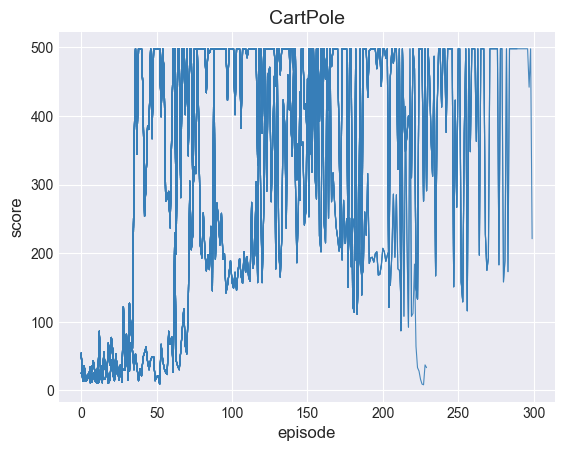

In [76]:
for i in range(3):
    agent = Agent()
    reward_output = agent.train()
    reward_list.append(reward_output)

In [77]:

for i in range(len(reward_list)):
    if np.mean(reward_list[i]) < 250:
        print(i)

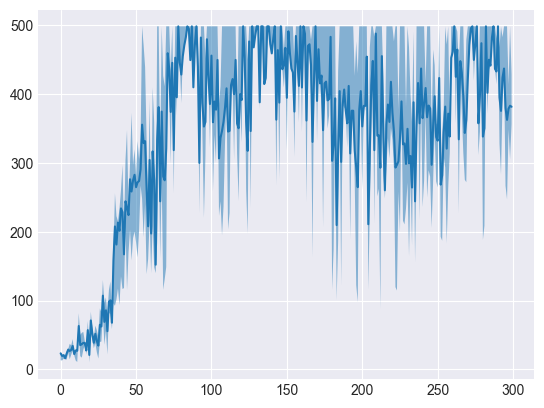

In [78]:
reward_list_trunc = [row[:300] for row in reward_list]
mean = np.mean(reward_list_trunc, axis = 0)
plt.plot(range(300), mean[:300])
par_1_75, par_1_25 = np.percentile(reward_list_trunc, [75, 25], axis = 0)
plt.fill_between(range(300), par_1_25[:300],  par_1_75[:300], alpha = 0.5)

In [79]:
import pickle
dataStore = {}

dataStore['PPO_GAE'] = reward_list_trunc
    
with open('./' + 'Results_PPO+GAE_CP' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file
